<a href="https://colab.research.google.com/github/Abdu1964/G6/blob/main/Logistic_Vs_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPARISON BETWEEN LOGISTIC REGRESSION AND NEURAL NETWORK**

The project is credit card risk assessment and it uses the German Credit Risk dataset, which classifies customers as good or bad credit risks based on attributes like credit history, employment duration, loan amount, and other personal factors.

the dataset can be found on "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

* give the same seed for models to have the same random sequence for fair comparison

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

**Load the dataset**

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = [
    'status', 'duration', 'credit_history', 'purpose', 'amount',
    'savings', 'employment_duration', 'installment_rate', 'personal_status_sex',
    'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans',
    'housing', 'existing_credits', 'job', 'num_dependents', 'telephone', 'foreign_worker', 'class'
]

# Load the data
df = pd.read_csv(url, sep=' ', header=None, names=column_names)
# convert target to binary: 1 = good, 2 = bad -> 0 = good, 1 = bad
df['class'] = df['class'].map({1: 0, 2: 1})


# basic information about the dataset
print("\nDataset Information:")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 1}")
print("\nFeature names:")
print(df.columns.tolist())
print("\nClass distribution:")
print(df['class'].value_counts())
print("\nClass balance percentage:")
print(df['class'].value_counts(normalize=True) * 100)
# print("\nFirst 5 rows of the dataset:")
# print(df.head())


Dataset Information:
Number of samples: 1000
Number of features: 20

Feature names:
['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'telephone', 'foreign_worker', 'class']

Class distribution:
class
0    700
1    300
Name: count, dtype: int64

Class balance percentage:
class
0    70.0
1    30.0
Name: proportion, dtype: float64


**Preprocess**

In [ ]:
# separate features and class
X = df.drop('class', axis=1)
y = df['class']

#identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# fill missing values for the numerical features
# using simple imputer's median startegy then scale the feature
# using standard
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# fill missing values for the catagorical features
# using simple imputer's most_frequent startegy then convert
# the catagorical features to on numbers using one hot encoding

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])

# split the data using 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Apply preprocessing to the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the number of features after preprocessing (needed for the neural network input size)
n_features = X_train_processed.shape[1]
print(f"Number of features after preprocessing: {n_features}")

Numeric features: ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'existing_credits', 'num_dependents']
Categorical features: ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
Training set size: 800
Testing set size: 200
Number of features after preprocessing: 61


**Train a scikit-learn Logistic regression model**

In [ ]:
# try models with different C values
c_values = [0.01, 0.1, 1, 10]
lr_models = {}

print("\nEvaluating Logistic Regression models with different C values:")
best_f1 = 0
best_c = None

for c in c_values:
    print(f"\nTraining and evaluating with C = {c}")
    lr_model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    lr_model.fit(X_train_processed, y_train)
    lr_models[c] = lr_model

    # predict
    y_pred = lr_model.predict(X_test_processed)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # check the best model based on F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_c = c

print(f"\nBest C value based on F1 score: {best_c}")
lr_model = lr_models[best_c]

# Make predictions on the test set with the best model
y_pred_lr = lr_model.predict(X_test_processed)


Evaluating Logistic Regression models with different C values:

Training and evaluating with C = 0.01
Accuracy: 0.7400
Precision: 0.7857
Recall: 0.1833
F1 Score: 0.2973

Training and evaluating with C = 0.1
Accuracy: 0.7900
Precision: 0.7143
Recall: 0.5000
F1 Score: 0.5882

Training and evaluating with C = 1
Accuracy: 0.7800
Precision: 0.6667
Recall: 0.5333
F1 Score: 0.5926

Training and evaluating with C = 10
Accuracy: 0.7750
Precision: 0.6364
Recall: 0.5833
F1 Score: 0.6087

Best C value based on F1 score: 10


**Train the pytorch neural network**

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed)
X_test_tensor = torch.FloatTensor(X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed)

y_train_tensor = torch.FloatTensor(y_train.values).float()
y_test_tensor = torch.FloatTensor(y_test.values).float()

# Check if labels are not in [0,1] range and normalize them if needed
if (y_train_tensor > 1).any() or (y_train_tensor < 0).any():
    # If labels are something like -1/1 or other values, convert to 0/1
    y_train_tensor = (y_train_tensor > 0).float()
    y_test_tensor = (y_test_tensor > 0).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# the neural network
class CreditRiskNN(nn.Module):
    def __init__(self, input_size):
        super(CreditRiskNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

model = CreditRiskNN(input_size=n_features)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        labels = labels.float()

        # Double-check that labels are between 0 and 1
        if (labels > 1).any() or (labels < 0).any():
            labels = (labels > 0).float()

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')
model.eval()
with torch.no_grad():
    y_pred_prob_nn = model(X_test_tensor).squeeze().numpy()
    y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

Epoch [10/100], Loss: 0.427703
Epoch [20/100], Loss: 0.277739
Epoch [30/100], Loss: 0.128554
Epoch [40/100], Loss: 0.056966
Epoch [50/100], Loss: 0.020806
Epoch [60/100], Loss: 0.009878
Epoch [70/100], Loss: 0.005280
Epoch [80/100], Loss: 0.003223
Epoch [90/100], Loss: 0.002083
Epoch [100/100], Loss: 0.001529


**Model evaluation function definition**

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nConfusion Matrix:")
    print(cm)


    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good Credit', 'Bad Credit'],
                yticklabels=['Good Credit', 'Bad Credit'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

**Actual evaluation**


Logistic Regression Metrics:
Accuracy: 0.7750
Precision: 0.6364
Recall: 0.5833
F1 Score: 0.6087

Confusion Matrix:
[[120  20]
 [ 25  35]]


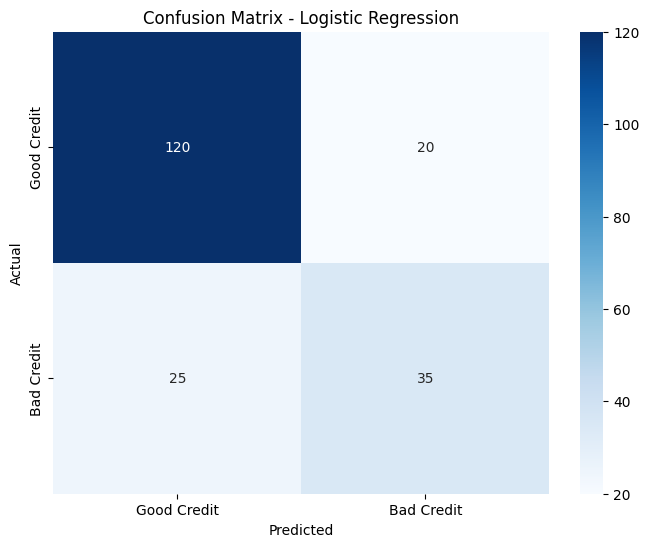


Neural Network Metrics:
Accuracy: 0.7850
Precision: 0.6491
Recall: 0.6167
F1 Score: 0.6325

Confusion Matrix:
[[120  20]
 [ 23  37]]


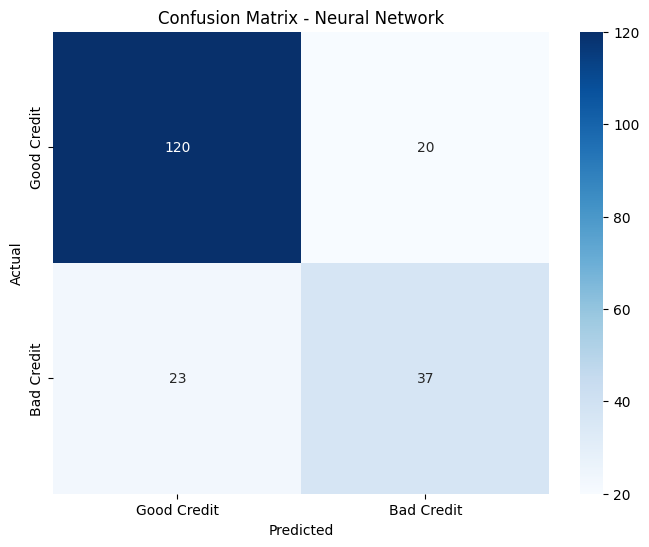


Comparing both models:


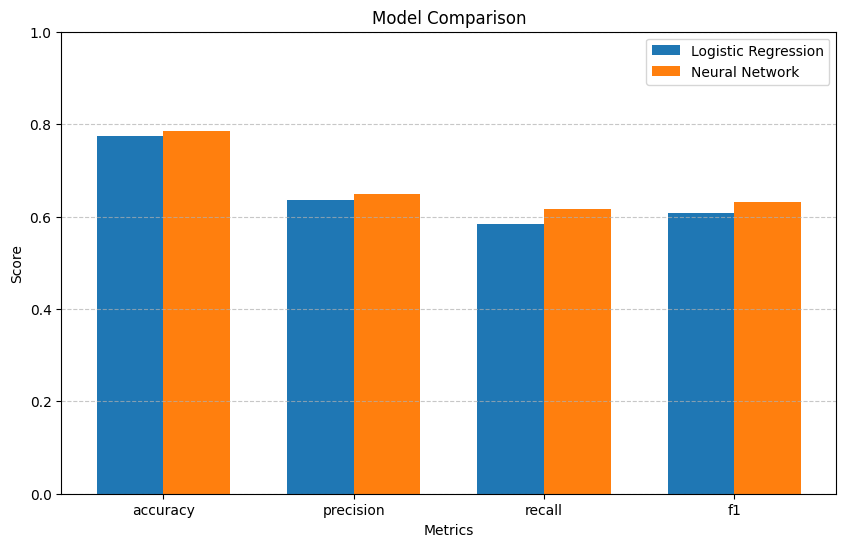

In [ ]:
lr_metrics = evaluate_model(y_test, y_pred_lr, "Logistic Regression")

nn_metrics = evaluate_model(y_test, y_pred_nn, "Neural Network")

# Compare models
print("\nComparing both models:")

metrics = ['accuracy', 'precision', 'recall', 'f1']
model_names = ['Logistic Regression', 'Neural Network']
lr_values = [lr_metrics[metric] for metric in metrics]
nn_values = [nn_metrics[metric] for metric in metrics]

# comparison bar chart
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, lr_values, width, label='Logistic Regression')
plt.bar(x + width/2, nn_values, width, label='Neural Network')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Logistic Regression (scikit-learn)**

Implementation: Standard logistic regression with different regularization strengths (C values)

2. **Neural Network (PyTorch)**

Implementation: 3-layer network with ReLU activation

Input layer → 64 neurons → 32 neurons → Output layer with sigmoid activation


**Performance Metrics Comparison**

Metric | Logistic-Regression| NeuralNetwork|

Accuracy     |  0.775    |   0.785

Precision    |  0.636    |   0.649

Recall       |  0.583    |   0.617

F1 Score     |  0.609     |   0.632


**Regularization Effects (C Parameter)**

Testing logistic regression with different C values (0.01, 0.1, 1, 10) revealed:

1. Lower C values (stronger regularization): reduced recall
2. Higher C values (weaker regularization): Improved recall but risked overfitting
3. Optimal value: C=1 provided the best balance of precision and recall for this dataset